# Self-Attention and Positional Encoding

[Sequence encoding using self-attention, including using additional information for the sequence order.](https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html)

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## Self-attention


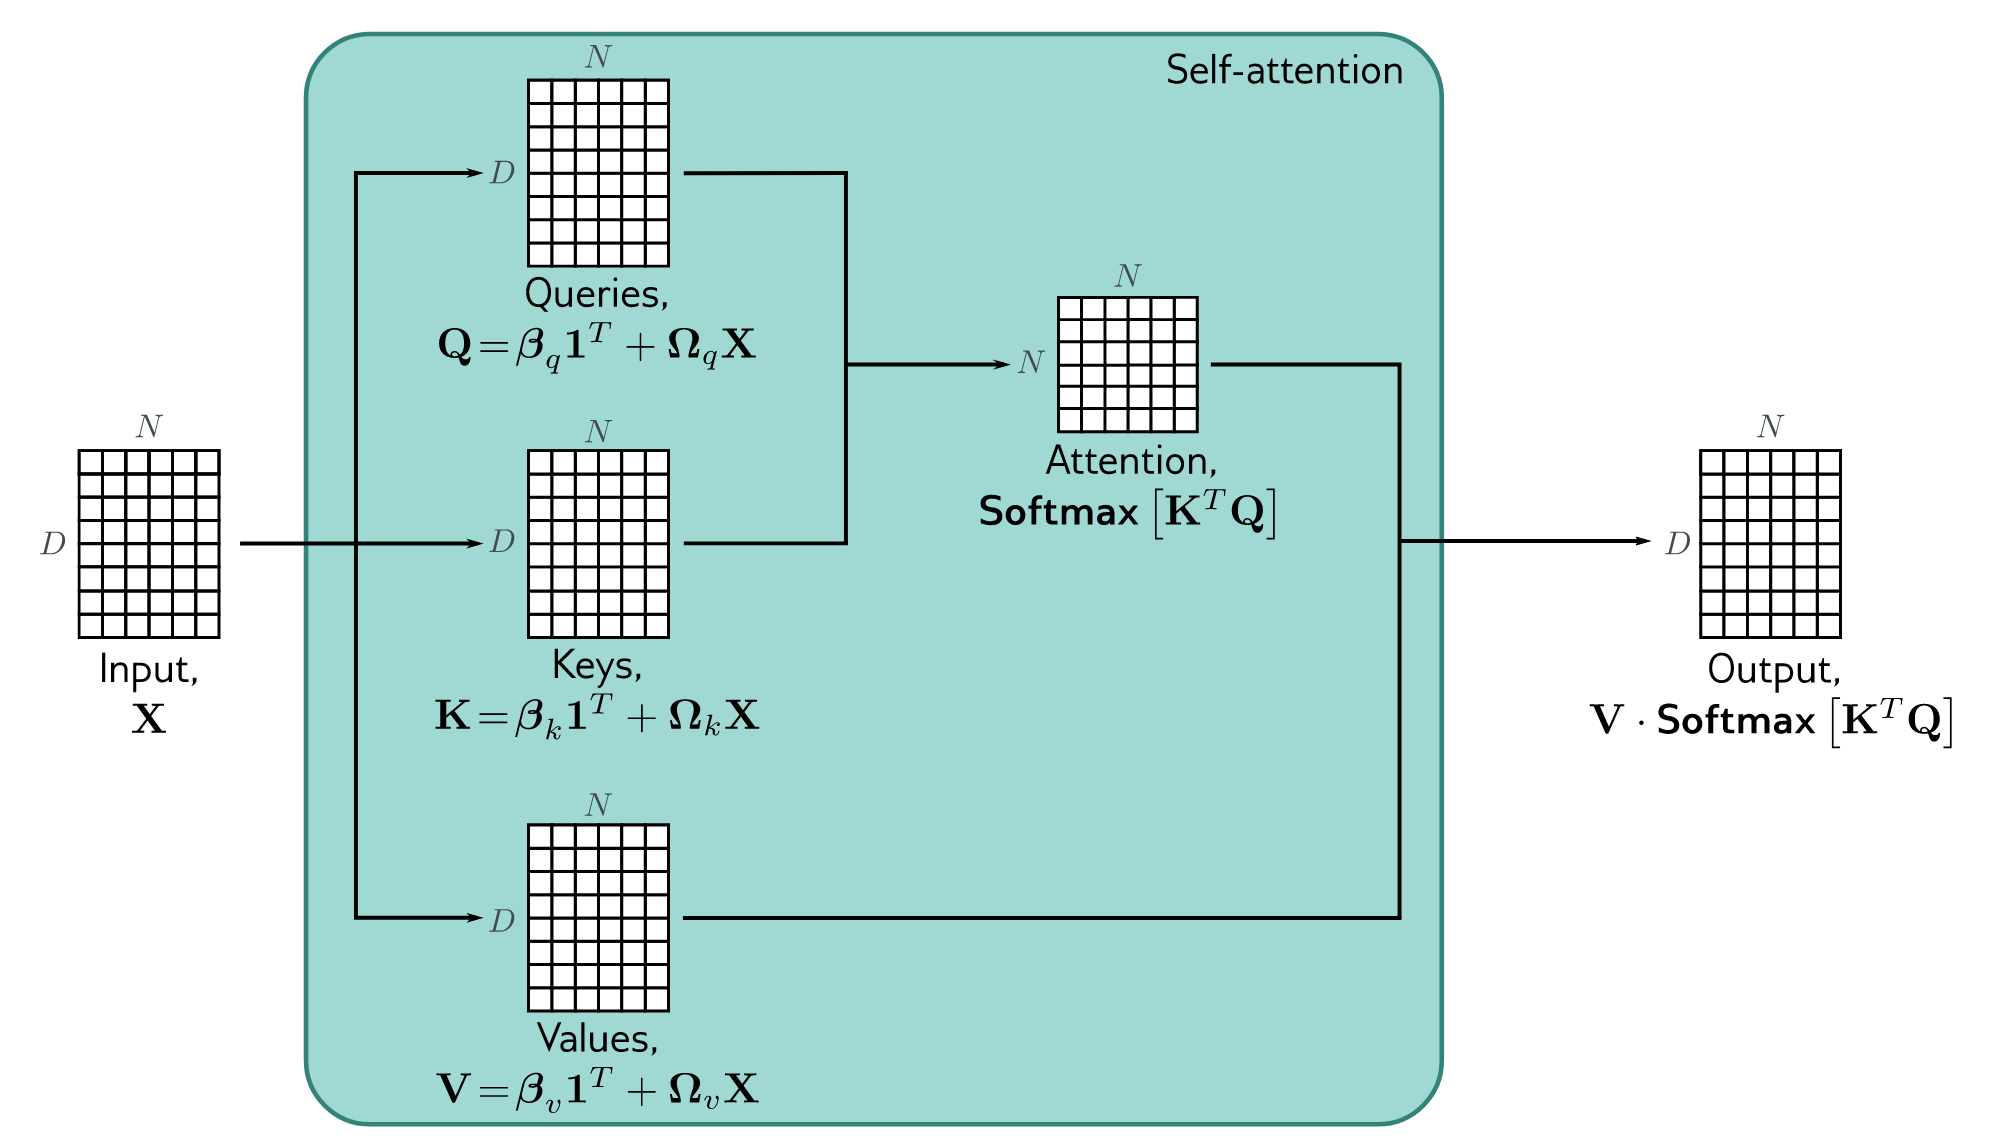

In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

/Users/zhouzhang/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Positional encoding


In [3]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In the positional embedding matrix $P$, **rows correspond to positions within a sequence** and **columns represent different positional encoding dimensions**. In the example below, we can see that the $6^{th}$ and the $7^{th}$ columns of the positional embedding matrix have a higher frequency than the $8^{th}$ and the $9^{th}$ columns. The offset between the $6^{th}$ and the $7^{th}$ (same for the $8^{th}$ and the $9^{th}$) columns is due to the alternation of sine and cosine functions.

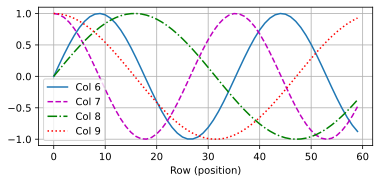

In [4]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### Absolute Positional Information

In [5]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations, a higher bit has a lower frequency than a lower bit. Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.

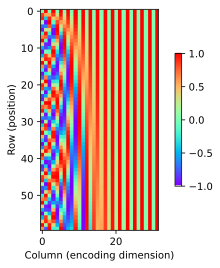

In [6]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(6, 4), cmap='rainbow')

### Relative Positional Information

## Summary

In self-attention, the queries, keys, and values all come from the same place. 
- Both CNNs and self-attention enjoy parallel computation and self-attention has the shortest maximum path length. 
- The quadratic computational complexity with respect to the sequence length makes self-attention prohibitively slow for very long sequences. 
- To use the sequence order information, we can inject absolute or relative positional information by adding positional encoding to the input representations.